In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.callbacks import EarlyStopping
import keras.backend as K
import numpy as np

# our stuff
from synth import *
from utils import *
from const import Tx, Ty, n_a, n_s, input_vocab, output_vocab, output_vocab_inv

import matplotlib.pyplot as plt
%matplotlib inline

/home/opyate/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Here I construct the model in code again. `model = load_model('themodel.h5')` followed by loading the weights doesn't yields predictions like `[1,1,1,1,1,1,1,1]`, and an all-blue graph in the attention map below.

In [2]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor = Dense(1, activation = "relu")
# softmax(axis = 1) from utils.py
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes = 1)

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a"
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis
    concat = concatenator([a, s_prev])
    # Use densor to propagate concat through a small fully-connected neural network to compute the "energies" variable e.
    e = densor(concat)
    # Use activator and e to compute the attention weights "alphas"
    alphas = activator(e)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell
    context = dotor([alphas, a])
    
    return context

post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(output_vocab), activation=softmax)

def get_model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    # Step 1: Define pre-attention Bi-LSTM. Remember to use return_sequences=True.
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs.
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    
    return model

model = get_model(Tx, Ty, n_a, n_s, len(input_vocab), len(output_vocab))

opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [3]:
import os

modelweightsfile = "themodel-weights.h5"
model.load_weights(modelweightsfile)
print('loaded weights')

loaded weights



r
(8, 1, 128, 1)
largest 0.082230255
Ty 8
Tx 128
predicted 12:05:07


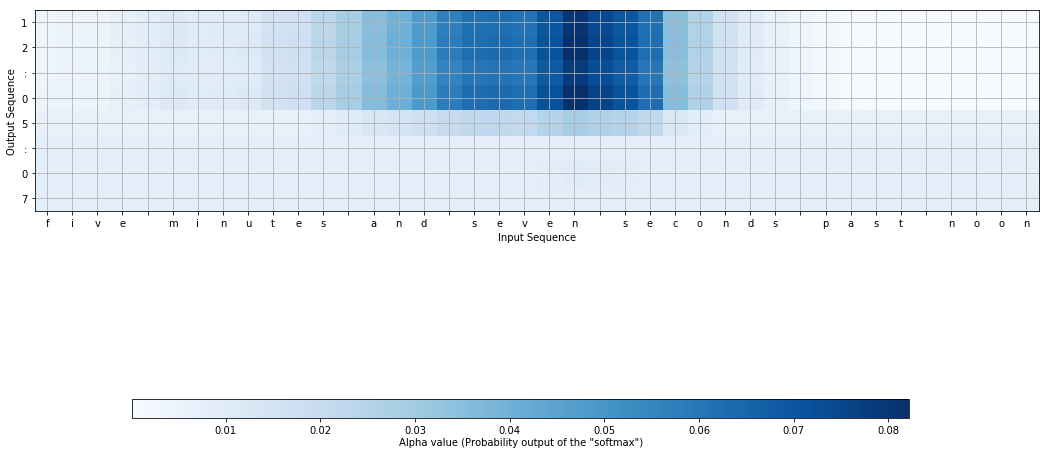

In [5]:
np.set_printoptions(threshold=np.nan)
def plot_attention_map2(model, input_vocabulary, inv_output_vocabulary, text, num, n_s, Tx, Ty):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((Ty, Tx))
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]

    encoded = np.array(string_to_int(text, Tx, input_vocabulary))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))
    
    #encoded = string_to_int(text, Tx, input_vocabulary)
    #encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), source))).swapaxes(0,1)
    
    f = K.function(model.inputs + [K.learning_phase()], [layer.get_output_at(t) for t in range(Ty)])
    r = f([np.expand_dims(encoded, axis=0), s0, c0, 0])
    
    #intermediate_layer_model = Model(inputs=model.input,outputs=[layer.get_output_at(t) for t in range(Ty)])
    #r = intermediate_layer_model.predict([encoded, s0, c0])

    print('\nr')
    print(np.array(r).shape)
    print('largest', np.max(r))
    #print(r[7][0])
    #print('\ns0')
    #print(s0)
    #print('\nc0')
    #print(c0)
    print('Ty', Ty)
    print('Tx', Tx)
    
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0,t_prime,0]

    # discard the part of the attention_map which is "padded"
    attention_map = attention_map[:, :len(text)]
    
    # Normalize attention map
    normalize = False
    if normalize:
        row_max = attention_map.max(axis=1)
        attention_map = attention_map / row_max[:, None]

    prediction = model.predict([np.expand_dims(encoded, axis=0), s0, c0])
    
    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    print('predicted', ''.join(predicted_text))
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(18, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length])

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

test = "five minutes and seven seconds past noon"
attention_map = plot_attention_map2(model, input_vocab, output_vocab_inv, test, 6, n_s, Tx, Ty)